In [18]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import linregress
import statsmodels.api as sm
import warnings # these two lines to remove the annoying warnings from pandas
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
# import ecopart data 
ecopart = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/Ecopart_diagnostics_data_655.tsv', delimiter = '\t')
ecopart = ecopart[['Profile', 'Date_Time', 'Depth [m]', 'Flux_mgC_m2', 'MiP_abun', 'MaP_abun']]
ecopart = ecopart[ecopart['Profile'].str.contains('a')]

ecopart['Date_Time'] = pd.to_datetime(ecopart['Date_Time'])

# Select only first 500 meters
depth_mask = (ecopart['Depth [m]'] >= 0) & (ecopart['Depth [m]'] <= 100)
flux_0_600 = ecopart[depth_mask]
flux_0_600

,Profile,Date_Time,Depth [m],Flux_mgC_m2,MiP_abun,MaP_abun
0,0000a_WMO6903095,2021-04-13 14:01:29,2.482344,26.8900,74.444,0.000000
1,0000a_WMO6903095,2021-04-13 14:01:29,7.446943,27.9880,61.945,0.208330
2,0000a_WMO6903095,2021-04-13 14:01:29,12.411420,28.5990,52.318,0.507250
3,0000a_WMO6903095,2021-04-13 14:01:29,17.375778,21.7140,48.266,0.200000
4,0000a_WMO6903095,2021-04-13 14:01:29,22.340015,20.7110,45.617,0.123460
...,...,...,...,...,...,...
42455,0183a_WMO6903095,2022-09-17 19:52:17,76.930374,10.8990,43.501,0.125000
42456,0183a_WMO6903095,2022-09-17 19:52:17,81.892630,11.3280,43.333,0.158730
42457,0183a_WMO6903095,2022-09-17 19:52:17,86.854770,10.9100,40.509,0.092592
42458,0183a_WMO6903095,2022-09-17 19:52:17,91.816780,12.2770,43.509,0.087719


In [33]:
# group by profiles and compute the flux mean
flux_0_600_mean = flux_0_600.groupby(['Profile']).agg({'MaP_abun' : ['mean','std'],
                                                   'MiP_abun' : ['mean','std'],
                                                   'Flux_mgC_m2' : ['mean','std']}).reset_index()
flux_0_600_mean.columns = {'Profile': 'Profile',
                         'MaP_abun_mean': 'MaP_abun_mean',
                         'MaP_abun_std': 'MaP_abun_mean_std',
                         'MiP_abun_mean': 'MiP_abun_mean',
                         'MiP_abun_std': 'MiP_abun_mean_std',
                         'Flux_mgC_m2_mean': 'Flux_mgC_m2_mean',
                         'Flux_mgC_m2_std': 'Flux_mgC_m2_std'}

flux_0_600_mean

,Profile,MaP_abun_mean,MaP_abun_std,MiP_abun_mean,MiP_abun_std,Flux_mgC_m2_mean,Flux_mgC_m2_std
0,0000a_WMO6903095,0.089981,0.124300,37.148150,13.791131,13.930475,7.598731
1,0001a_WMO6903095,0.421680,0.282936,39.910950,18.383336,21.333490,11.927833
2,0002a_WMO6903095,0.422912,0.223202,42.918300,19.623686,23.075250,9.348185
3,0003a_WMO6903095,0.120198,0.117049,36.211556,15.598005,12.915100,6.797522
4,0004a_WMO6903095,0.168045,0.109189,40.379111,15.884792,15.841367,7.585305
...,...,...,...,...,...,...,...
179,0179a_WMO6903095,0.124188,0.108192,41.477450,3.450769,12.971870,8.337403
180,0180a_WMO6903095,0.168029,0.101100,57.678550,13.281075,17.324270,6.895016
181,0181a_WMO6903095,0.396354,0.239775,90.452450,32.808377,34.741750,15.668838
182,0182a_WMO6903095,0.111100,0.072367,44.483500,4.366690,13.046785,6.067877


In [34]:
# Import lagrangian data
lagrangian = pd.read_csv("/home/aaccardo/Accardo_et_al/Data/lagrangian/final_data_an35be.csv")

# select only ascent profiles
lagrangian = lagrangian[lagrangian['Profile'].str.contains('a')]

#select only lagrangian chlorophyll data
lagrangian_chla = lagrangian[['Profile',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_000daysBackward_mean',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_005daysBackward_mean',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_010daysBackward_mean',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_020daysBackward_mean',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_025daysBackward_mean',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_030daysBackward_mean',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_035daysBackward_mean',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_040daysBackward_mean',
     'Lagr_Chl_GlobEkmanDt_Oceancolour_045daysBackward_mean']]

lagrangian_chla

,Profile,Lagr_Chl_GlobEkmanDt_Oceancolour_000daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_005daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_010daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_020daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_025daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_030daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_035daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_040daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_045daysBackward_mean
0,0000a_WMO6903095,0.199519,0.166135,0.164166,0.182874,0.186411,0.182890,0.186633,0.182798,0.178186,0.177629
2,0001a_WMO6903095,0.199182,0.167555,0.167270,0.185966,0.188905,0.185148,0.188577,0.184785,0.180218,0.179801
4,0002a_WMO6903095,0.198920,0.168346,0.168766,0.186260,0.189248,0.185467,0.188892,0.185256,0.180931,0.180922
6,0003a_WMO6903095,0.167785,0.163239,0.176863,0.191338,0.195151,0.192661,0.195121,0.192410,0.185974,0.184908
8,0004a_WMO6903095,0.166088,0.162695,0.176748,0.190830,0.195602,0.192714,0.195797,0.193069,0.186552,0.185282
...,...,...,...,...,...,...,...,...,...,...,...
358,0179a_WMO6903095,0.198079,0.204065,0.170436,0.159859,0.154730,0.154446,0.148155,0.146762,0.145199,0.146012
360,0180a_WMO6903095,0.247393,0.219064,0.178430,0.168026,0.160549,0.159251,0.152050,0.149966,0.147964,0.147872
362,0181a_WMO6903095,0.265088,0.227036,0.190261,0.176399,0.167163,0.164786,0.157309,0.154388,0.151755,0.150768
364,0182a_WMO6903095,0.278876,0.237706,0.204415,0.185616,0.174418,0.170893,0.162587,0.158882,0.155944,0.153755


In [35]:
# merge both 
flux_lagrangian_chla = pd.merge(flux_0_600_mean, lagrangian_chla, on='Profile')
flux_lagrangian_chla

,Profile,MaP_abun_mean,MaP_abun_std,MiP_abun_mean,MiP_abun_std,Flux_mgC_m2_mean,Flux_mgC_m2_std,Lagr_Chl_GlobEkmanDt_Oceancolour_000daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_005daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_010daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_020daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_025daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_030daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_035daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_040daysBackward_mean,Lagr_Chl_GlobEkmanDt_Oceancolour_045daysBackward_mean
0,0000a_WMO6903095,0.089981,0.124300,37.148150,13.791131,13.930475,7.598731,0.199519,0.166135,0.164166,0.182874,0.186411,0.182890,0.186633,0.182798,0.178186,0.177629
1,0001a_WMO6903095,0.421680,0.282936,39.910950,18.383336,21.333490,11.927833,0.199182,0.167555,0.167270,0.185966,0.188905,0.185148,0.188577,0.184785,0.180218,0.179801
2,0002a_WMO6903095,0.422912,0.223202,42.918300,19.623686,23.075250,9.348185,0.198920,0.168346,0.168766,0.186260,0.189248,0.185467,0.188892,0.185256,0.180931,0.180922
3,0003a_WMO6903095,0.120198,0.117049,36.211556,15.598005,12.915100,6.797522,0.167785,0.163239,0.176863,0.191338,0.195151,0.192661,0.195121,0.192410,0.185974,0.184908
4,0004a_WMO6903095,0.168045,0.109189,40.379111,15.884792,15.841367,7.585305,0.166088,0.162695,0.176748,0.190830,0.195602,0.192714,0.195797,0.193069,0.186552,0.185282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0179a_WMO6903095,0.124188,0.108192,41.477450,3.450769,12.971870,8.337403,0.198079,0.204065,0.170436,0.159859,0.154730,0.154446,0.148155,0.146762,0.145199,0.146012
180,0180a_WMO6903095,0.168029,0.101100,57.678550,13.281075,17.324270,6.895016,0.247393,0.219064,0.178430,0.168026,0.160549,0.159251,0.152050,0.149966,0.147964,0.147872
181,0181a_WMO6903095,0.396354,0.239775,90.452450,32.808377,34.741750,15.668838,0.265088,0.227036,0.190261,0.176399,0.167163,0.164786,0.157309,0.154388,0.151755,0.150768
182,0182a_WMO6903095,0.111100,0.072367,44.483500,4.366690,13.046785,6.067877,0.278876,0.237706,0.204415,0.185616,0.174418,0.170893,0.162587,0.158882,0.155944,0.153755


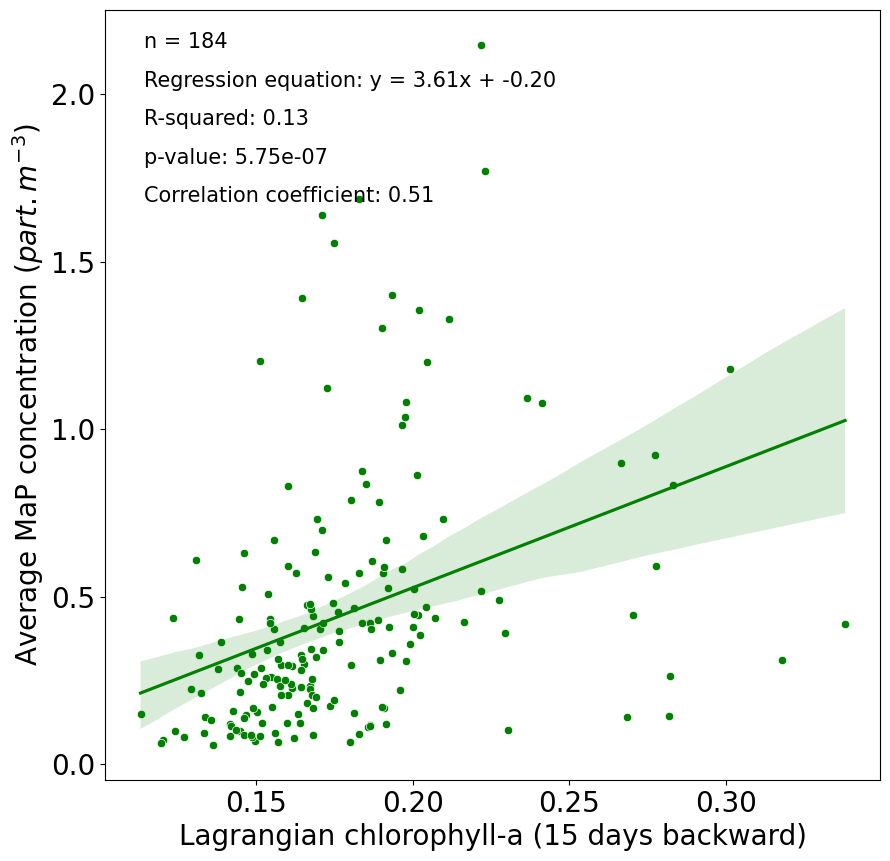

In [39]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(data=flux_lagrangian_chla, y='MaP_abun_mean',
                x='Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean', color='green')

# Perform linear regression
X = flux_lagrangian_chla['Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean']
y = flux_lagrangian_chla['MaP_abun_mean']
X = sm.add_constant(X)  # Add a constant term to the independent variable
model = sm.OLS(y, X).fit()

# Add the linear regression line
sns.regplot(data=flux_lagrangian_chla, y='MaP_abun_mean', x='Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean',
            scatter=False, color='green', ci = 95)

# Add the regression equation
slope, intercept = model.params['Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean'], model.params['const']

# Add R-squared, p-value, and correlation coefficient annotations
r_squared = model.rsquared
p_value = model.f_pvalue
corr_coef = flux_lagrangian_chla['MaP_abun_mean'].corr(flux_lagrangian_chla['Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean'], method='spearman')

plt.text(0.05, 0.95, f'n = {len(flux_lagrangian_chla)}', transform=ax.transAxes, size=15)
plt.text(0.05, 0.9, f'Regression equation: y = {slope:.2f}x + {intercept:.2f}', transform=ax.transAxes, size=15)
plt.annotate(f'R-squared: {r_squared:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', size=15)
plt.annotate(f'p-value: {p_value:.2e}', xy=(0.05, 0.80), xycoords='axes fraction', size=15)
plt.annotate(f'Correlation coefficient: {corr_coef:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', size=15)

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average MaP concentration ($part.m^{-3}$)', size=20)
plt.xlabel('Lagrangian chlorophyll-a (15 days backward)', size=20)
plt.savefig('/home/aaccardo/Accardo_et_al/Figures/correlations/Map_lagr_chla_0_100_corr.png', dpi=300)
plt.show()

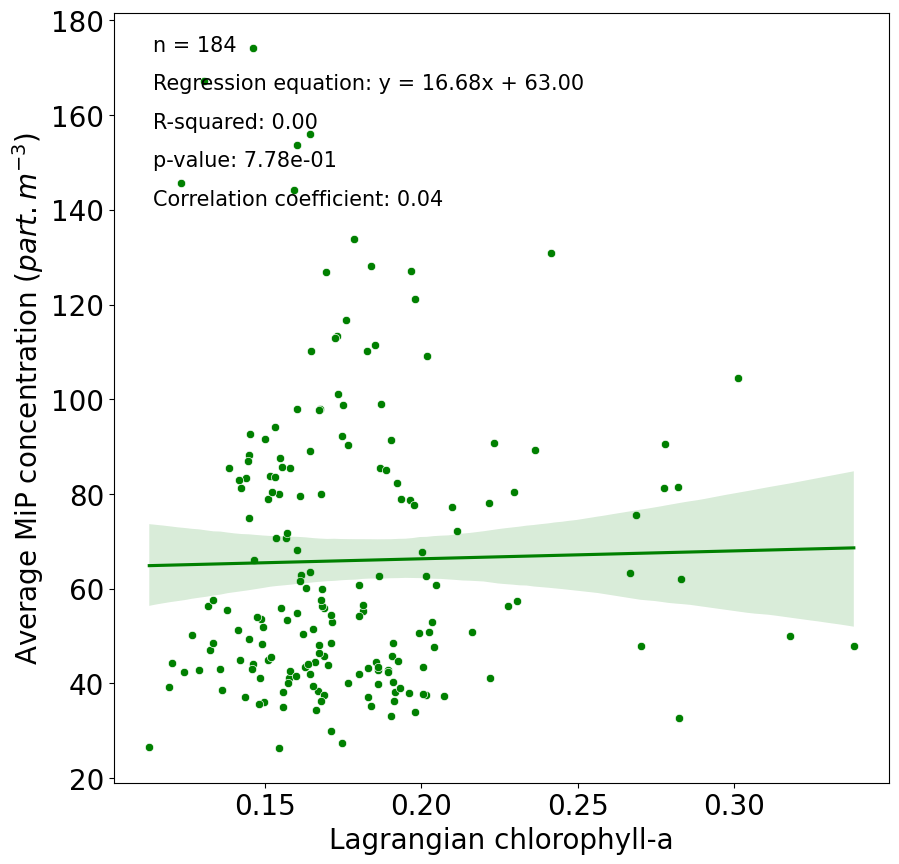

In [38]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(data=flux_lagrangian_chla, y='MiP_abun_mean',
                x='Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean', color='green')

# Perform linear regression
X = flux_lagrangian_chla['Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean']
y = flux_lagrangian_chla['MiP_abun_mean']
X = sm.add_constant(X)  # Add a constant term to the independent variable
model = sm.OLS(y, X).fit()

# Add the linear regression line
sns.regplot(data=flux_lagrangian_chla, y='MiP_abun_mean', x='Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean',
            scatter=False, color='green', ci = 95)

# Add the regression equation
slope, intercept = model.params['Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean'], model.params['const']

# Add R-squared, p-value, and correlation coefficient annotations
r_squared = model.rsquared
p_value = model.f_pvalue
corr_coef = flux_lagrangian_chla['MiP_abun_mean'].corr(flux_lagrangian_chla['Lagr_Chl_GlobEkmanDt_Oceancolour_015daysBackward_mean'], method='spearman')

plt.text(0.05, 0.95, f'n = {len(flux_lagrangian_chla)}', transform=ax.transAxes, size=15)
plt.text(0.05, 0.9, f'Regression equation: y = {slope:.2f}x + {intercept:.2f}', transform=ax.transAxes, size=15)
plt.annotate(f'R-squared: {r_squared:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', size=15)
plt.annotate(f'p-value: {p_value:.2e}', xy=(0.05, 0.80), xycoords='axes fraction', size=15)
plt.annotate(f'Correlation coefficient: {corr_coef:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', size=15)

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average MiP concentration ($part.m^{-3}$)', size=20)
plt.xlabel('Lagrangian chlorophyll-a', size=20)
#plt.savefig('/home/aaccardo/Accardo_et_al/Figures/correlations/Map_lagr_chla_corr.png', dpi=300)
plt.show()

In [63]:
# Look with front 

front = lagrangian[['Profile',
        'Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010', 'Ftle_GlobEkmanDt_010daysBackward_mean_delta0ftle010',
        'Ftle_GlobEkmanDt_015daysBackward_mean_delta0ftle010', 'Ftle_GlobEkmanDt_020daysBackward_mean_delta0ftle010',
        'Ftle_GlobEkmanDt_030daysBackward_mean_delta0ftle010', 'Ftle_GlobEkmanDt_045daysBackward_mean_delta0ftle010']]

In [64]:
# select only productive period 
date_mask = (ecopart['Date_Time'] >= '2021-10-15 00:00:00') & (ecopart['Date_Time'] <= '2022-04-23')
flux_prod_period = ecopart[date_mask]
flux_prod_period

,Profile,Date_Time,Depth [m],Flux_mgC_m2,MiP_abun,MaP_abun
12805,0067a_WMO6903095,2021-10-17 19:52:25,2.481658,63.4020,92.490,0.761320
12806,0067a_WMO6903095,2021-10-17 19:52:25,7.444884,72.0770,99.865,1.036000
12807,0067a_WMO6903095,2021-10-17 19:52:25,12.407989,112.8600,148.300,1.742400
12808,0067a_WMO6903095,2021-10-17 19:52:25,17.370974,72.8200,99.233,0.945960
12809,0067a_WMO6903095,2021-10-17 19:52:25,22.333841,65.6090,100.470,0.729160
...,...,...,...,...,...,...
30158,0129a_WMO6903095,2022-04-21 19:52:51,957.963560,7.6611,21.833,0.000000
30159,0129a_WMO6903095,2022-04-21 19:52:51,962.902700,3.9924,18.667,0.000000
30160,0129a_WMO6903095,2022-04-21 19:52:51,967.841860,8.9954,24.583,0.000000
30161,0129a_WMO6903095,2022-04-21 19:52:51,972.780800,7.1886,24.643,0.000000


In [65]:
# select only 0-100 m depth 
depth_mask = (flux_prod_period['Depth [m]'] >= 0) & (flux_prod_period['Depth [m]'] <= 1000)
flux_prod_period_surface = flux_prod_period[depth_mask]
flux_prod_period_surface

,Profile,Date_Time,Depth [m],Flux_mgC_m2,MiP_abun,MaP_abun
12805,0067a_WMO6903095,2021-10-17 19:52:25,2.481658,63.4020,92.490,0.761320
12806,0067a_WMO6903095,2021-10-17 19:52:25,7.444884,72.0770,99.865,1.036000
12807,0067a_WMO6903095,2021-10-17 19:52:25,12.407989,112.8600,148.300,1.742400
12808,0067a_WMO6903095,2021-10-17 19:52:25,17.370974,72.8200,99.233,0.945960
12809,0067a_WMO6903095,2021-10-17 19:52:25,22.333841,65.6090,100.470,0.729160
...,...,...,...,...,...,...
30158,0129a_WMO6903095,2022-04-21 19:52:51,957.963560,7.6611,21.833,0.000000
30159,0129a_WMO6903095,2022-04-21 19:52:51,962.902700,3.9924,18.667,0.000000
30160,0129a_WMO6903095,2022-04-21 19:52:51,967.841860,8.9954,24.583,0.000000
30161,0129a_WMO6903095,2022-04-21 19:52:51,972.780800,7.1886,24.643,0.000000


In [66]:
# group by profiles and compute the flux mean
flux_prod_period_surface_mean = flux_prod_period_surface.groupby(['Profile']).agg({'MaP_abun' : ['mean','std'],
                                                   'MiP_abun' : ['mean','std'],
                                                   'Flux_mgC_m2' : ['mean','std']}).reset_index()
flux_prod_period_surface_mean.columns = {'Profile': 'Profile',
                         'MaP_abun_mean': 'MaP_abun_mean',
                         'MaP_abun_std': 'MaP_abun_mean_std',
                         'MiP_abun_mean': 'MiP_abun_mean',
                         'MiP_abun_std': 'MiP_abun_mean_std',
                         'Flux_mgC_m2_mean': 'Flux_mgC_m2_mean',
                         'Flux_mgC_m2_std': 'Flux_mgC_m2_std'}

flux_prod_period_surface_mean

,Profile,MaP_abun_mean,MaP_abun_std,MiP_abun_mean,MiP_abun_std,Flux_mgC_m2_mean,Flux_mgC_m2_std
0,0067a_WMO6903095,0.264839,0.301732,47.318954,25.185397,22.894269,33.634506
1,0068a_WMO6903095,0.227067,0.233417,53.316770,16.321973,20.593805,13.117393
2,0069a_WMO6903095,0.236130,0.519780,43.787731,18.030490,22.271654,44.983339
3,0070a_WMO6903095,0.167222,0.222462,49.047891,6.865144,18.190197,14.698668
4,0071a_WMO6903095,0.100725,0.147868,39.552124,11.338549,14.390134,16.646633
...,...,...,...,...,...,...,...
58,0125a_WMO6903095,0.222946,0.239743,41.999639,33.967593,15.065585,11.697417
59,0126a_WMO6903095,0.181965,0.212046,41.305201,32.281705,13.900864,10.251335
60,0127a_WMO6903095,0.129184,0.159121,37.586787,19.037558,11.651440,5.836710
61,0128a_WMO6903095,0.086123,0.145464,35.447450,19.091578,9.755421,6.616326


In [67]:
flux_lagrangian_ftle = pd.merge(flux_prod_period_surface_mean, front, on='Profile')
flux_lagrangian_ftle

,Profile,MaP_abun_mean,MaP_abun_std,MiP_abun_mean,MiP_abun_std,Flux_mgC_m2_mean,Flux_mgC_m2_std,Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010,Ftle_GlobEkmanDt_010daysBackward_mean_delta0ftle010,Ftle_GlobEkmanDt_015daysBackward_mean_delta0ftle010,Ftle_GlobEkmanDt_020daysBackward_mean_delta0ftle010,Ftle_GlobEkmanDt_030daysBackward_mean_delta0ftle010,Ftle_GlobEkmanDt_045daysBackward_mean_delta0ftle010
0,0067a_WMO6903095,0.264839,0.301732,47.318954,25.185397,22.894269,33.634506,0.272520,0.163279,0.128880,0.098785,0.093803,0.072551
1,0068a_WMO6903095,0.227067,0.233417,53.316770,16.321973,20.593805,13.117393,0.350722,0.157799,0.116771,0.100390,0.083683,0.067954
2,0069a_WMO6903095,0.236130,0.519780,43.787731,18.030490,22.271654,44.983339,0.363888,0.232527,0.162970,0.125418,0.081853,0.066075
3,0070a_WMO6903095,0.167222,0.222462,49.047891,6.865144,18.190197,14.698668,0.083229,0.162830,0.142429,0.105302,0.084990,0.058368
4,0071a_WMO6903095,0.100725,0.147868,39.552124,11.338549,14.390134,16.646633,0.143577,0.192726,0.176591,0.143649,0.094833,0.061244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0125a_WMO6903095,0.222946,0.239743,41.999639,33.967593,15.065585,11.697417,0.232988,0.210872,0.172761,0.136640,0.101753,0.068889
59,0126a_WMO6903095,0.181965,0.212046,41.305201,32.281705,13.900864,10.251335,0.125783,0.139049,0.099471,0.117748,0.100444,0.069710
60,0127a_WMO6903095,0.129184,0.159121,37.586787,19.037558,11.651440,5.836710,0.275026,0.245853,0.206998,0.160083,0.099482,0.067529
61,0128a_WMO6903095,0.086123,0.145464,35.447450,19.091578,9.755421,6.616326,0.155326,0.095437,0.134206,0.116353,0.100097,0.070157


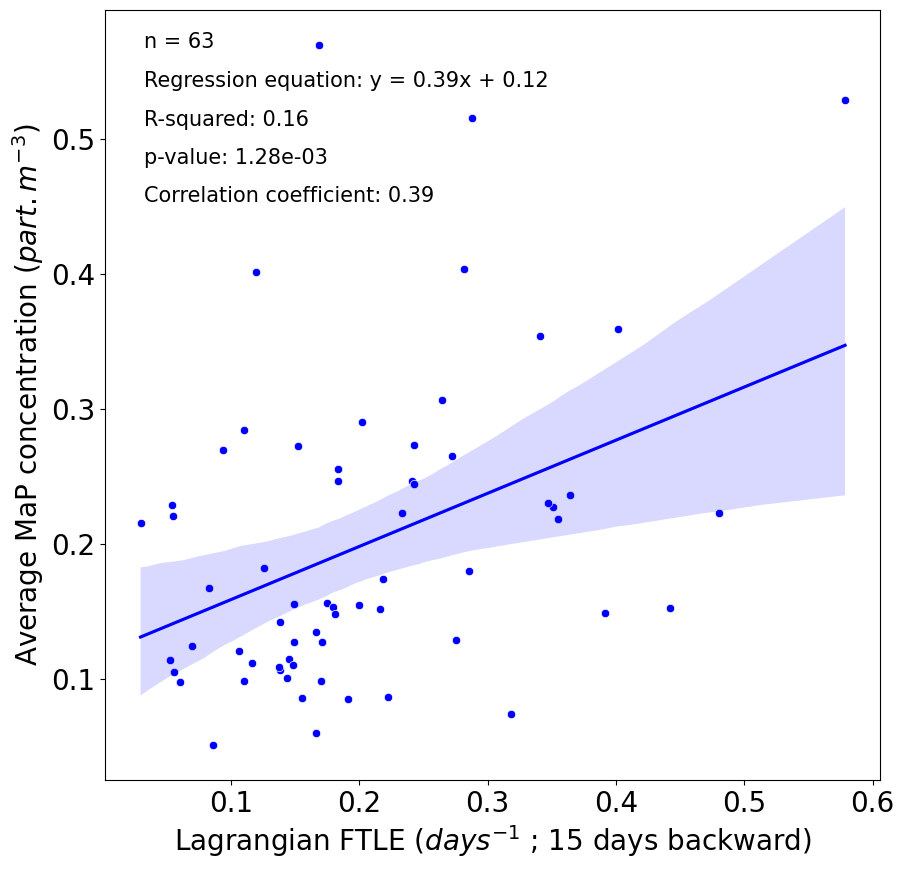

In [68]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(data=flux_lagrangian_ftle, y='MaP_abun_mean',
                x='Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010', color='blue')

# Perform linear regression
X = flux_lagrangian_ftle['Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010']
y = flux_lagrangian_ftle['MaP_abun_mean']
X = sm.add_constant(X)  # Add a constant term to the independent variable
model = sm.OLS(y, X).fit()

# Add the linear regression line
sns.regplot(data=flux_lagrangian_ftle, y='MaP_abun_mean', x='Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010',
            scatter=False, color='blue', ci = 95)

# Add the regression equation
slope, intercept = model.params['Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010'], model.params['const']

# Add R-squared, p-value, and correlation coefficient annotations
r_squared = model.rsquared
p_value = model.f_pvalue
corr_coef = flux_lagrangian_ftle['MaP_abun_mean'].corr(flux_lagrangian_ftle['Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010'], method='spearman')

plt.text(0.05, 0.95, f'n = {len(flux_lagrangian_ftle)}', transform=ax.transAxes, size=15)
plt.text(0.05, 0.9, f'Regression equation: y = {slope:.2f}x + {intercept:.2f}', transform=ax.transAxes, size=15)
plt.annotate(f'R-squared: {r_squared:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', size=15)
plt.annotate(f'p-value: {p_value:.2e}', xy=(0.05, 0.80), xycoords='axes fraction', size=15)
plt.annotate(f'Correlation coefficient: {corr_coef:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', size=15)

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average MaP concentration ($part.m^{-3}$)', size=20)
plt.xlabel('Lagrangian FTLE ($days^{-1}$ ; 15 days backward)', size=20)
#plt.savefig('/home/aaccardo/Accardo_et_al/Figures/correlations/Map_lagr_chla_0_100_corr.png', dpi=300)
plt.show()